# 정규화 미적용

[TRAIN] 교집합 개수: 1026 / TS=1026 ST=1026
[VALID] 교집합 개수: 127 / TS=127 ST=127
[TEST] 교집합 개수: 130 / TS=130 ST=130


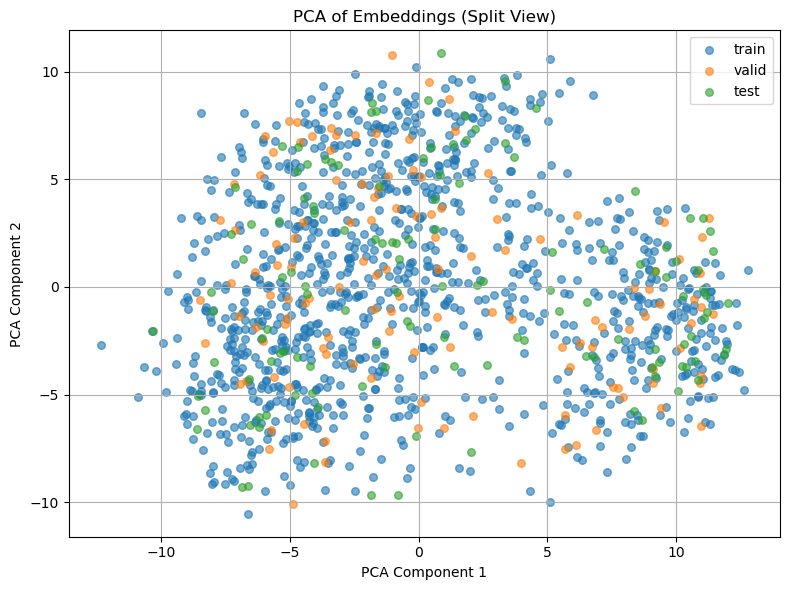

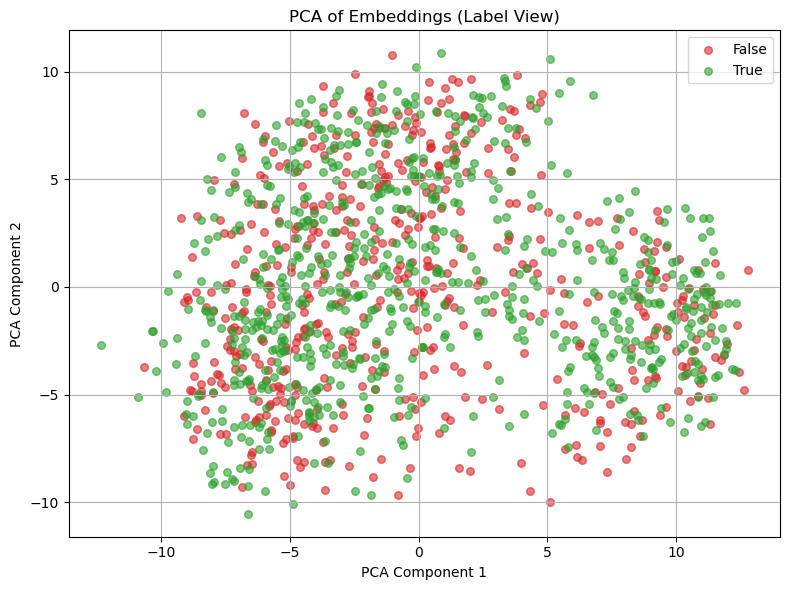

In [ ]:
# 📌 통합 PCA 시각화: TimeSformer + ST-GCN 정렬 포함
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path

# ───────────── 설정 ─────────────
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "max"  # "mean", "max", "flatten" 중 선택

# ───────────── 함수 정의 ─────────────
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    # 만약 타입이 다르면 str로 통일
    ids_ts = np.array(ids_ts).astype(str)
    ids_st = np.array(ids_st).astype(str)

    inter = set(ids_ts) & set(ids_st)
    print(f"[{split.upper()}] 교집합 개수: {len(inter)} / TS={len(ids_ts)} ST={len(ids_st)}")
    if len(inter) == 0:
        print(f"❌ {split} : 두 ids 간 교집합이 0개입니다. 파일, 타입, 경로 재확인 필요!")
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"❌ {split} 정렬 실패: TS={len(X_ts)}, ST={len(X_st)}")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y


# ───────────── 정렬 및 결합 ─────────────
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

X_all = np.vstack([X_tr, X_va, X_te])
y_all_split = (
    ["train"] * len(X_tr) +
    ["valid"] * len(X_va) +
    ["test"]  * len(X_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

if len(X_all) == 0:
    raise ValueError("모든 split에서 정렬된 데이터가 없습니다. 경로 및 ID 정렬 상태를 확인하세요.")

# ───────────── PCA 변환 ─────────────
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all)

# ───────────── 시각화 1: split 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split) if s == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.6, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (Split View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ───────────── 시각화 2: 라벨 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['False', 'True']):
    idx = y_all_label == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=name, alpha=0.6, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (Label View)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# 정규화 적용

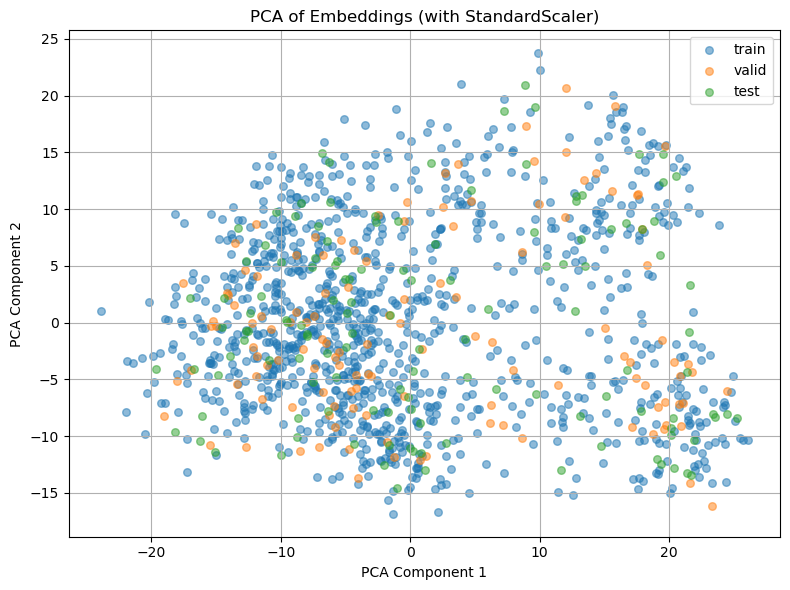

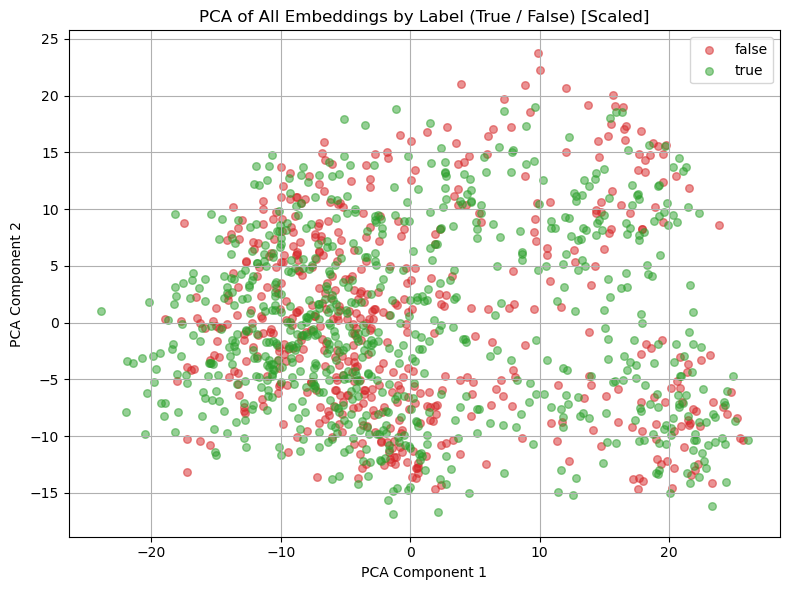

In [ ]:
# 📌 TimeSformer + ST-GCN 임베딩 결합 (ID 정렬 포함, StandardScaler)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# ───────────── 설정 ─────────────
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "max"  # "mean", "max", "flatten" 중 선택

# ───────────── 함수 정의 ─────────────
def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        print(f"⚠️ {split}/{model} 경로에 필요한 파일이 없습니다. 스킵합니다.")
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"❌ {split} 정렬 실패: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y

# ───────────── 정렬 및 결합 ─────────────
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

X_all = np.vstack([X_tr, X_va, X_te])
y_all_split = (
    ["train"] * len(X_tr) +
    ["valid"] * len(X_va) +
    ["test"]  * len(X_te)
)
y_all_label = np.concatenate([y_tr, y_va, y_te])

if len(X_all) == 0:
    raise ValueError("모든 split에서 정렬된 데이터가 없습니다. 경로 및 ID 정렬 상태를 확인하세요.")

# ───────────── 정규화 및 PCA ─────────────
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))  # train+valid 기준으로 fit
X_tr_scaled = scaler.transform(X_tr)
X_va_scaled = scaler.transform(X_va)
X_te_scaled = scaler.transform(X_te)
X_all_scaled = np.vstack([X_tr_scaled, X_va_scaled, X_te_scaled])

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_all_scaled)

# ───────────── 시각화 1: split 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color in zip(['train', 'valid', 'test'], ['tab:blue', 'tab:orange', 'tab:green']):
    idx = [i for i, s in enumerate(y_all_split) if s == label]
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=label, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of Embeddings (with StandardScaler)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ───────────── 시각화 2: 라벨 기준 ─────────────
plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all_label == label
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=name, alpha=0.5, s=30, color=color)
plt.legend()
plt.title("PCA of All Embeddings by Label (True / False) [Scaled]")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# t-SNE UMAP

In [ ]:
# 📌 TimeSformer + ST-GCN t-SNE/UMAP 시각화 (ID 정렬 결합 버전)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# ---------- [아래는 PCA와 동일한 ID 정렬 & 결합 파트] ----------
DATA_ROOT = Path(r"D:\Jabez\golf\fusion\embedding_data")
AGG_METHOD = "mean"  # "mean", "max", "flatten" 중 선택

def load_split(split, model):
    base = DATA_ROOT / model / split
    emb_path = base / "embeddings.npy"
    lbl_path = base / "labels.npy"
    ids_path = base / "ids.npy"
    if not emb_path.exists() or not lbl_path.exists() or not ids_path.exists():
        print(f"⚠️ {split}/{model} 경로에 필요한 파일이 없습니다. 스킵합니다.")
        return None, None, None
    emb = np.load(emb_path)
    lbl = np.load(lbl_path).ravel()
    ids = np.load(ids_path, allow_pickle=True).ravel()
    return emb, lbl, ids

def reduce_stgcn(arr):
    if arr is None or len(arr) == 0:
        return np.empty((0, 0))
    if AGG_METHOD == "mean":    return np.nanmean(arr, axis=1)
    if AGG_METHOD == "max":     return np.nanmax(arr, axis=1)
    if AGG_METHOD == "flatten": return arr.reshape(arr.shape[0], -1)
    raise ValueError("Invalid AGG_METHOD")

def align_by_ids(base_ids, target_embs, target_ids):
    id_to_emb = {k: v for k, v in zip(target_ids, target_embs)}
    aligned_embs = [id_to_emb[i] for i in base_ids if i in id_to_emb]
    return np.array(aligned_embs)

def load_and_align(split):
    X_ts, y, ids_ts = load_split(split, "timesformer")
    X_st, _, ids_st = load_split(split, "stgcnpp")

    if X_ts is None or X_st is None:
        return np.empty((0, 0)), np.array([])

    X_st = align_by_ids(ids_ts, X_st, ids_st)
    X_st = reduce_stgcn(X_st)

    if len(X_ts) != len(X_st):
        print(f"❌ {split} 정렬 실패: TS={len(X_ts)}, ST={len(X_st)})")
        return np.empty((0, 0)), np.array([])

    X_concat = np.concatenate([X_ts, X_st], axis=1)
    return X_concat, y

# 정렬 및 결합
X_tr, y_tr = load_and_align("train")
X_va, y_va = load_and_align("valid")
X_te, y_te = load_and_align("test")

if len(X_tr) == 0 or len(X_va) == 0 or len(X_te) == 0:
    raise ValueError("train/valid/test split 데이터 정렬 실패. ID 일치 여부 확인!")

# ---------- [정규화 및 통합] ----------
scaler = StandardScaler().fit(np.vstack([X_tr, X_va]))
X_tr_scaled = scaler.transform(X_tr)
X_va_scaled = scaler.transform(X_va)
X_te_scaled = scaler.transform(X_te)

X_all = np.vstack([X_tr_scaled, X_va_scaled, X_te_scaled])
y_all = np.concatenate([y_tr, y_va, y_te])

# ---------- [t-SNE 시각화] ----------
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_all)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("t-SNE of Embeddings (True / False)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- [UMAP 시각화] ----------
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_all)

plt.figure(figsize=(8, 6))
for label, color, name in zip([0, 1], ['tab:red', 'tab:green'], ['false', 'true']):
    idx = y_all == label
    plt.scatter(X_umap[idx, 0], X_umap[idx, 1], label=name, alpha=0.5, s=30, color=color)

plt.legend()
plt.title("UMAP of Embeddings (True / False)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


⚠️ train/timesformer 경로에 필요한 파일이 없습니다. 스킵합니다.
⚠️ train/stgcnpp 경로에 필요한 파일이 없습니다. 스킵합니다.
⚠️ valid/timesformer 경로에 필요한 파일이 없습니다. 스킵합니다.
⚠️ valid/stgcnpp 경로에 필요한 파일이 없습니다. 스킵합니다.
⚠️ test/timesformer 경로에 필요한 파일이 없습니다. 스킵합니다.
⚠️ test/stgcnpp 경로에 필요한 파일이 없습니다. 스킵합니다.


ValueError: train/valid/test split 데이터 정렬 실패. ID 일치 여부 확인!